In [ ]:
# Author: Jack Kelly

In [1]:
import tensorflow.compat.v2 as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow_model_optimization as tfmot
import numpy as np
from qkeras import print_qstats
from qkeras import QActivation
from qkeras import QDense
from qkeras import quantized_bits
from qkeras import ternary
from qkeras.estimate import print_qstats
from qkeras.estimate import extract_model_operations
from qkeras.utils import quantized_model_debug
from qkeras.utils import model_save_quantized_weights
from qkeras.utils import model_quantize
import pandas as pd
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import tempfile
import os
import sys
import csv
import zipfile
import math
import time
%matplotlib inline

In [2]:
# Reproducibility
seed = 9 # arbitrary number
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

In [3]:
N_channels = 40
data_path = os.getcwd()
print(data_path)

/Users/jackkelly/Desktop/Submission


In [4]:
### IMPORT, SHUFFLE AND SCALE DATA ###
def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y

In [5]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    return os.path.getsize(zipped_file)

In [6]:
file_path = f'{data_path}/Data/10000_initial_data.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
file_path = f'{data_path}/Data/10000_initial_data_testing.csv'
X_test, Y_test = processing_data(N_channels, file_path)
model = keras.models.load_model(f'{data_path}/Tuned_ANN_model.h5')
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
batch_size = 32
epochs = 100
validation_split = 0.2

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 140)               5880      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               14100     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
Total params: 24,020
Trainable params: 24,020
Non-trainable params: 0
_________________________________________________________________


In [8]:
def prune_and_quantize(desired_sparsity, quantized_bit_number):
    file_path = f'{data_path}/Data/10000_initial_data.csv'
    X_scale, Y_scale = processing_data(N_channels, file_path)
    file_path = f'{data_path}/Data/10000_initial_data_testing.csv'
    X_test, Y_test = processing_data(N_channels, file_path)
    model = keras.models.load_model(f'{data_path}/Tuned_ANN_model.h5')
    print('---------------------------')
    print(f'Desired sparsity: {desired_sparsity}, Quantized bit number: {quantized_bit_number}')
    config = {
      "QDense": {
          "kernel_quantizer": f"quantized_bits({quantized_bit_number},0,1)",
          "bias_quantizer": f"quantized_bits({quantized_bit_number})"
      },
      "QActivation": { "relu": f"quantized_bits({quantized_bit_number})" },
    }
    qmodel = model_quantize(model, config, 16, transfer_weights=True)
    qmodel.summary()
    pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=desired_sparsity, begin_step=0, end_step=-1, frequency=200)
    }
    pruned_q_model = prune_low_magnitude(qmodel, **pruning_params)
    # 'prune_low_magnitude' requires a recompile.
    pruned_q_model.compile(optimizer=keras.optimizers.Adam(),
                        loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep(),
    ]
    pruned_q_model.fit(X_scale, Y_scale,
                      batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=callbacks, verbose=0)
    eval_pruned_model = pruned_q_model.evaluate(X_test, Y_test, verbose=0)[1]
    print(f'Pruned model MSE: {eval_pruned_model}')
    qmodel_stripped = tfmot.sparsity.keras.strip_pruning(pruned_q_model)
    print_qstats(qmodel_stripped)
    _, pruned_keras_file = tempfile.mkstemp('.h5')
    tf.keras.models.save_model(qmodel_stripped, pruned_keras_file, include_optimizer=False)
    print('Saved pruned Keras model to:', pruned_keras_file)
    # Size of model after pruning
    size = get_gzipped_model_size(pruned_keras_file)
    print("Size of gzipped baseline Keras model: %.2f bytes" % (size))
    print('---------------------------')
    return eval_pruned_model, size, qmodel_stripped

In [9]:
# baseline model size
model = keras.models.load_model(f'{data_path}/Tuned_ANN_model.h5')
_, baseline_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, baseline_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', baseline_keras_file)
# Size of model after pruning
baseline_size = get_gzipped_model_size(baseline_keras_file)
print("Size of gzipped baseline Keras model: %.2f bytes" % (baseline_size))

Saved pruned Keras model to: /var/folders/yp/nbwcv8453t3f3sx3xxwwycqm0000gn/T/tmpet6l33ca.h5
Size of gzipped baseline Keras model: 91232.00 bytes


In [10]:
size_results = []
model_performance = []
quantized_bit_numbers = [4, 8, 12, 16]
sparsity_list = [0.2, 0.4, 0.6, 0.8]
for i in quantized_bit_numbers:
    for j in sparsity_list:
        eval_pruned_model, size, qmodel_stripped = prune_and_quantize(j, i)
        model_performance.append(eval_pruned_model)
        size_results.append(size)

---------------------------
Desired sparsity: 0.2, Quantized bit number: 4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (QDense)               (None, 140)               5880      
_________________________________________________________________
dense_1 (QDense)             (None, 100)               14100     
_________________________________________________________________
dense_2 (QDense)             (None, 40)                4040      
Total params: 24,020
Trainable params: 24,020
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Please use `layer.add_weight` method instead.
Pruned model MSE: 0.003684904193505645
Instructions for updating:
Use ref() instead.

Number of operations in model:
    dense                         : 5740  (smult_4_8)
    dense_1                       : 14000 (smult_4_16)
    dens

---------------------------
Desired sparsity: 0.2, Quantized bit number: 8
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (QDense)               (None, 140)               5880      
_________________________________________________________________
dense_1 (QDense)             (None, 100)               14100     
_________________________________________________________________
dense_2 (QDense)             (None, 40)                4040      
Total params: 24,020
Trainable params: 24,020
Non-trainable params: 0
_________________________________________________________________
Pruned model MSE: 0.0010242335265502334

Number of operations in model:
    dense                         : 5740  (smult_8_8)
    dense_1                       : 14000 (smult_8_16)
    dense_2                       : 4000  (smult_8_16)

Number of operation types in model:
    smult_8_16                    

Pruned model MSE: 0.0009007519693113863

Number of operations in model:
    dense                         : 5740  (smult_12_8)
    dense_1                       : 14000 (smult_12_16)
    dense_2                       : 4000  (smult_12_16)

Number of operation types in model:
    smult_12_16                   : 18000
    smult_12_8                    : 5740

Weight profiling:
    dense_weights                  : 5740  (12-bit unit)
    dense_bias                     : 140   (12-bit unit)
    dense_1_weights                : 14000 (12-bit unit)
    dense_1_bias                   : 100   (12-bit unit)
    dense_2_weights                : 4000  (12-bit unit)
    dense_2_bias                   : 40    (12-bit unit)

Weight sparsity:
... quantizing model
    dense                          : 0.1957
    dense_1                        : 0.1989
    dense_2                        : 0.1980
    ----------------------------------------
    Total Sparsity                 : 0.1980
Saved pruned Keras m

---------------------------
Desired sparsity: 0.4, Quantized bit number: 16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (QDense)               (None, 140)               5880      
_________________________________________________________________
dense_1 (QDense)             (None, 100)               14100     
_________________________________________________________________
dense_2 (QDense)             (None, 40)                4040      
Total params: 24,020
Trainable params: 24,020
Non-trainable params: 0
_________________________________________________________________
Pruned model MSE: 0.0006994351861067116

Number of operations in model:
    dense                         : 5740  (smult_16_8)
    dense_1                       : 14000 (smult_16_16)
    dense_2                       : 4000  (smult_16_16)

Number of operation types in model:
    smult_16_16               

In [11]:
print(size_results)
print(model_performance[0:4])
print(model_performance[4:8])
print(model_performance[8:12])
print(model_performance[12:16])

[20154, 18263, 15478, 10228, 36382, 31119, 24108, 15160, 49584, 41553, 31526, 19013, 61233, 50170, 37249, 21837]
[0.003684904193505645, 0.004853051621466875, 0.00451493076980114, 0.007322986610233784]
[0.0010242335265502334, 0.0006165684899315238, 0.0009321015095338225, 0.0026803845539689064]
[0.0009007519693113863, 0.0006477246643044055, 0.0011243440676480532, 0.0020059479866176844]
[0.00075480219675228, 0.0006994351861067116, 0.0007503205561079085, 0.0021303833927959204]


# Model sizes (bytes)

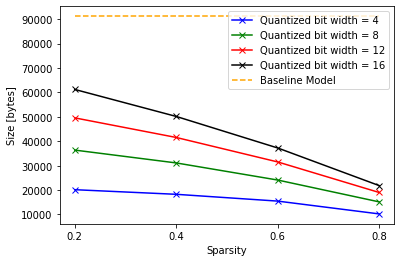

In [12]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
x = ['0.2','0.4','0.6','0.8']
values = np.array(size_results)
plt.plot(x, values[0:4], 'x-', color=colors['blue'], label='Quantized bit width = 4')
plt.plot(x, values[4:8], 'x-', color=colors['green'], label='Quantized bit width = 8')
plt.plot(x, values[8:12], 'x-', color=colors['red'], label='Quantized bit width = 12')
plt.plot(x, values[12:16], 'x-', color=colors['black'], label='Quantized bit width = 16')
baseline_size_list = [baseline_size]*4
plt.plot(x, baseline_size_list, '--', color=colors['orange'], label='Baseline Model')
plt.ylabel('Size [bytes]')
plt.xlabel('Sparsity')
# plt.ylim([0, 105000])
plt.legend()
plt.savefig(f'{data_path}/Figures/PQ/sizes.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

# Performance

313/313 [==============================] - 0s 534us/step - loss: 8.5572e-04 - mean_squared_error: 1.9442e-04 - mean_absolute_error: 0.0100


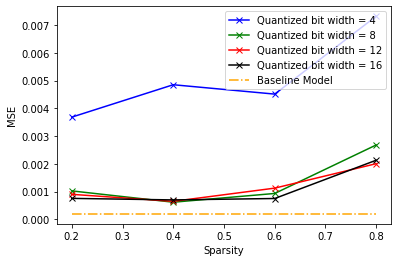

In [13]:
# setting up baseline non-quantized model's performance
baseline_model_performance = [model.evaluate(X_test, Y_test, verbose=1)[1]]*4
q4 = model_performance[0:4]
q8 = model_performance[4:8]
q12 = model_performance[8:12]
q16 = model_performance[12:16]
plt.figure()
plt.plot(sparsity_list, q4, 'x-', label='Quantized bit width = 4', color='blue')
plt.plot(sparsity_list, q8, 'x-', label='Quantized bit width = 8', color='green')
plt.plot(sparsity_list, q12, 'x-', label='Quantized bit width = 12', color='red')
plt.plot(sparsity_list, q16, 'x-', label='Quantized bit width = 16', color='black')
plt.plot(sparsity_list, baseline_model_performance, '-.', label='Baseline Model', color='orange')
plt.ylabel('MSE')
plt.xlabel('Sparsity')
plt.legend()
plt.savefig(f'{data_path}/Figures/PQ/pruning_and_quantization_MSE_epochs.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

# Bit operations (BOPs)

In [14]:
# using formula
def bop_calculator(n, m, bw, ba, fp):
    num = m*n*((1-fp)*ba*bw + ba + bw + math.log(n, 2))
    return num

# where n (m) is the number of inputs (outputs),
# bw (ba) is the bit width of the weights (activations),
# and fp is the fraction of pruned layer weights

In [15]:
# network nodes: 41 -> 140 -> 100 -> 40
sparsity_list = [0.2, 0.4, 0.6, 0.8]
quantized_bit_numbers = [4, 8, 12, 16]
bit_operations_comparison = []
for q_width in quantized_bit_numbers:
    for sparsity in sparsity_list:
        total_BOPs = 0
        total_BOPs += bop_calculator(41*140, 140, q_width, q_width, sparsity)
        total_BOPs += bop_calculator(140*100, 100, q_width, q_width, sparsity)
        total_BOPs += bop_calculator(100*40, 40, q_width, 16, sparsity)
        print(f'Quantized to {q_width} bits with a model sparsity of {sparsity}: {total_BOPs}')
        bit_operations_comparison.append(total_BOPs)
        
# baseline model
total_BOPs = 0
# total_BOPs += bop_calculator(41, 41, 32, 32, 0)
total_BOPs += bop_calculator(41*140, 140, 32, 32, 0)
total_BOPs += bop_calculator(140*100, 100, 32, 32, 0)
total_BOPs += bop_calculator(100*40, 40, 32, 32, 0)
print(total_BOPs)
for i in range(4):
    bit_operations_comparison.append(total_BOPs)

Quantized to 4 bits with a model sparsity of 0.2: 88458220.99828157
Quantized to 4 bits with a model sparsity of 0.4: 79358700.99828157
Quantized to 4 bits with a model sparsity of 0.6: 70259180.99828157
Quantized to 4 bits with a model sparsity of 0.8: 61159660.99828157
Quantized to 8 bits with a model sparsity of 0.2: 199537260.9982816
Quantized to 8 bits with a model sparsity of 0.4: 167235180.99828157
Quantized to 8 bits with a model sparsity of 0.6: 134933100.99828157
Quantized to 8 bits with a model sparsity of 0.8: 102631020.99828157
Quantized to 12 bits with a model sparsity of 0.2: 367028460.99828166
Quantized to 12 bits with a model sparsity of 0.4: 297420780.99828154
Quantized to 12 bits with a model sparsity of 0.6: 227813100.9982816
Quantized to 12 bits with a model sparsity of 0.8: 158205420.99828157
Quantized to 16 bits with a model sparsity of 0.2: 590931820.9982815
Quantized to 16 bits with a model sparsity of 0.4: 469915500.99828154
Quantized to 16 bits with a model s

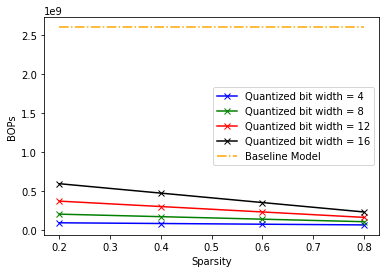

In [16]:
# Plotting BOPs
plt.figure()
q4_bitop = bit_operations_comparison[0:4]
q8_bitop = bit_operations_comparison[4:8]
q12_bitop = bit_operations_comparison[8:12]
q16_bitop = bit_operations_comparison[12:16]
baseline_model_BOPs = bit_operations_comparison[16:20]
plt.plot(sparsity_list, q4_bitop, 'x-', label='Quantized bit width = 4', color='blue')
plt.plot(sparsity_list, q8_bitop, 'x-', label='Quantized bit width = 8', color='green')
plt.plot(sparsity_list, q12_bitop, 'x-', label='Quantized bit width = 12', color='red')
plt.plot(sparsity_list, q16_bitop, 'x-', label='Quantized bit width = 16', color='black')
plt.plot(sparsity_list, baseline_model_BOPs, '-.', label='Baseline Model', color='orange')
plt.ylabel('BOPs')
plt.xlabel('Sparsity')
plt.legend()
plt.savefig(f'{data_path}/Figures/PQ/BOPs.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

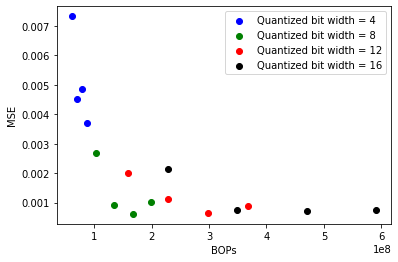

In [17]:
plt.figure()
plt.scatter(q4_bitop, q4, color='blue', label='Quantized bit width = 4')
plt.scatter(q8_bitop, q8, color='green', label='Quantized bit width = 8')
plt.scatter(q12_bitop, q12, color='red', label='Quantized bit width = 12')
plt.scatter(q16_bitop, q16, color='black', label='Quantized bit width = 16')
plt.ylabel('MSE')
plt.xlabel('BOPs')
plt.legend()
plt.savefig(f'{data_path}/Figures/PQ/BOPs_vs_Performance.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

In [18]:
eval_pruned_model, size, qmodel_stripped = prune_and_quantize(0.6, 8)

---------------------------
Desired sparsity: 0.6, Quantized bit number: 8
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (QDense)               (None, 140)               5880      
_________________________________________________________________
dense_1 (QDense)             (None, 100)               14100     
_________________________________________________________________
dense_2 (QDense)             (None, 40)                4040      
Total params: 24,020
Trainable params: 24,020
Non-trainable params: 0
_________________________________________________________________
Pruned model MSE: 0.0006912207463756204

Number of operations in model:
    dense                         : 5740  (smult_8_8)
    dense_1                       : 14000 (smult_8_16)
    dense_2                       : 4000  (smult_8_16)

Number of operation types in model:
    smult_8_16                    

In [19]:
qmodel_stripped.get_weights()

[array([[ 0.09179688,  0.        ,  0.12890625, ...,  0.20507812,
         -0.02929688,  0.08984375],
        [-0.1953125 ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.0078125 ,
         -0.125     ,  0.12109375],
        ...,
        [ 0.        ,  0.        ,  0.19921875, ...,  0.        ,
          0.03125   ,  0.16992188],
        [ 0.        ,  0.08007812,  0.        , ...,  0.046875  ,
          0.        ,  0.        ],
        [-0.0859375 ,  0.0625    ,  0.        , ...,  0.        ,
          0.02539062,  0.        ]], dtype=float32),
 array([ 0.3125   ,  0.       ,  0.2890625,  0.3515625,  0.34375  ,
         0.296875 ,  0.3671875,  0.0078125,  0.265625 ,  0.3515625,
         0.3828125,  0.2890625,  0.3203125,  0.3359375,  0.2421875,
         0.359375 ,  0.2265625, -0.046875 ,  0.       ,  0.375    ,
         0.2109375,  0.2734375,  0.2109375,  0.390625 ,  0.3125   ,
         0.1484375

# CDF plot

In [20]:
df = pd.read_csv(f'{data_path}/Data/10000_initial_data_testing.csv')
# dataset
dataset = df.values
# input power and channels statuses
X = dataset[:,0:N_channels+1]
Y = dataset[:,N_channels+1:2*N_channels+1]

xScaler = preprocessing.MinMaxScaler()
yScaler = preprocessing.MinMaxScaler()

xScaler.fit(X)
yScaler.fit(Y)

xTrainNorm = xScaler.transform(X)
yTrainNorm = yScaler.transform(Y)

start_time = time.time()
y_predicted = qmodel_stripped.predict(xTrainNorm)
y_predicted_inverted = yScaler.inverse_transform(y_predicted)
prediction_time = time.time() - start_time
print(prediction_time)

0.8579840660095215


90th percentile mse =  1.8940268468396162 dB
90th percentile mae =  0.9957858568056605 dB
Average MSE = 0.743443499279237
Average MAE = 0.4669349665701333


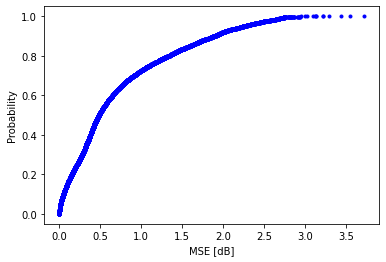

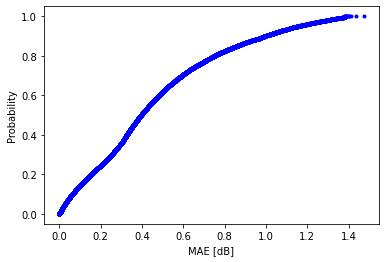

In [21]:
def CDF_plot(x, y, e_type):
    plt.figure()
    mse_ecdf = plt.plot(x,y, marker='.', linestyle='none', color='blue')
    plt.xlabel(f'{e_type} [dB]')
    plt.ylabel('Probability')
    plt.savefig(f'{data_path}/Figures/PQ/CDF_plot_QP_{e_type}.svg', bbox_inches='tight', format='svg', dpi=1200)
    plt.show()
    
mean_squared_error_store = []
mean_absolute_error_store = []
for i in range(10000):
    mean_squared_error_store.append(mean_squared_error(y_predicted_inverted[i], Y[i]))
    mean_absolute_error_store.append(mean_absolute_error(y_predicted_inverted[i], Y[i]))
x_mse = np.sort(mean_squared_error_store)
x_mae = np.sort(mean_absolute_error_store)
y = np.arange(1, len(x_mse)+1)/len(x_mse)
print('90th percentile mse = ', x_mse[9000],'dB')
print('90th percentile mae = ', x_mae[9000],'dB')
print(f'Average MSE = {np.mean(x_mse)}')
print(f'Average MAE = {np.mean(x_mae)}')
CDF_plot(x_mse, y, 'MSE')
CDF_plot(x_mae, y, 'MAE')

# Bar plot

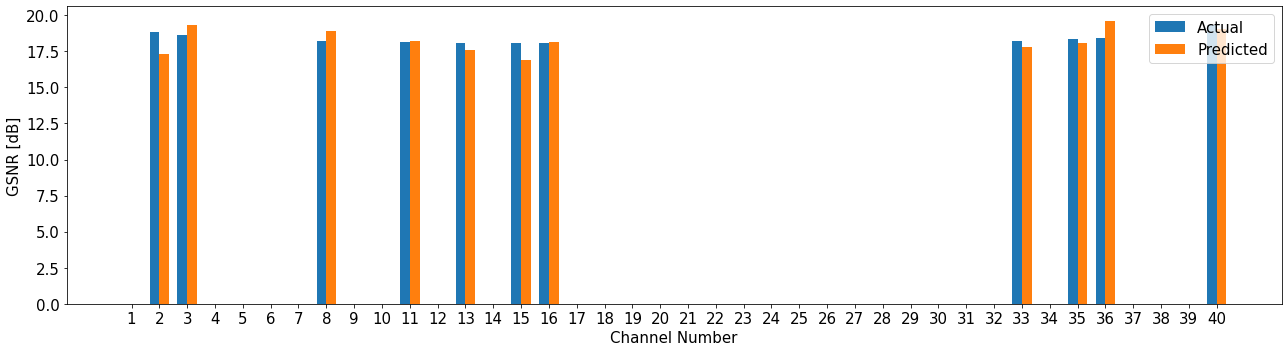

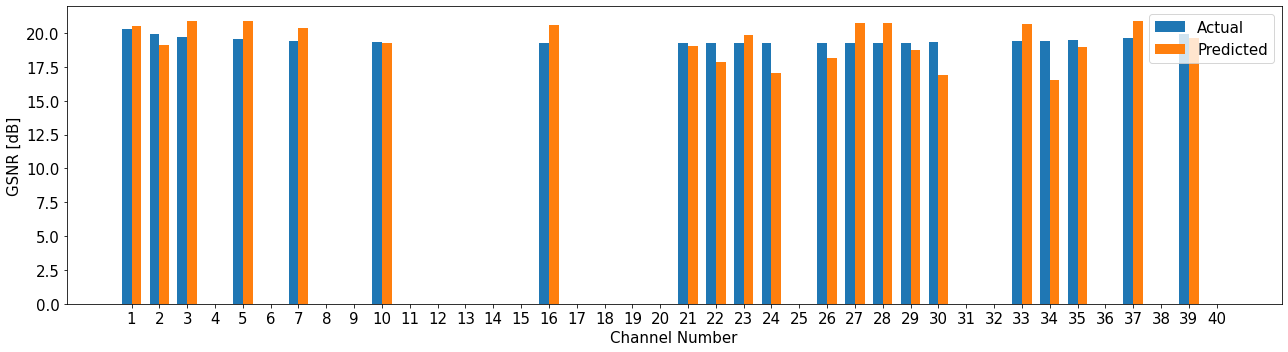

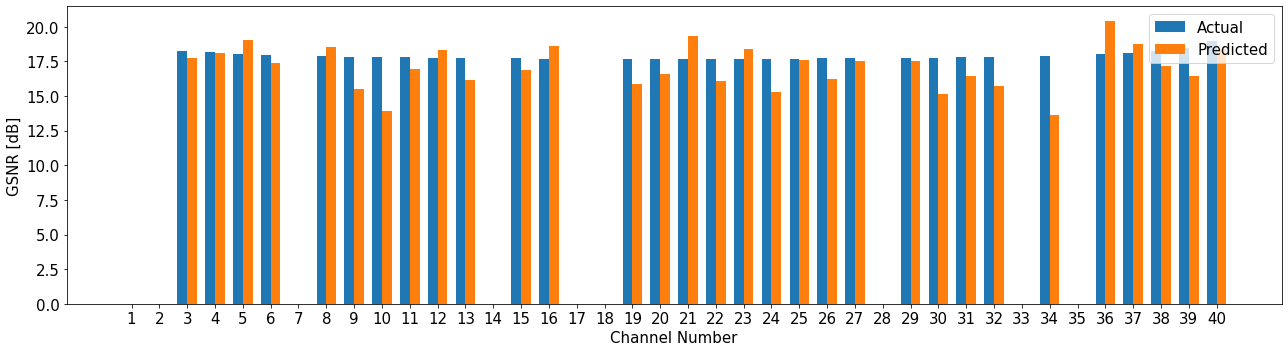

In [22]:
def barplot(index):
    y_actual = Y[index] * X[index][1:]
    y_predicted = y_predicted_inverted[index] * X[index][1:]
    
    labels = [i for i in range(1,41)]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(18,5))
    # plt.figure(figsize=(25,5))
    rects1 = ax.bar(x - width/2, y_actual, width, label='Actual')
    rects2 = ax.bar(x + width/2, y_predicted, width, label='Predicted')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('GSNR [dB]', fontsize=15)
    ax.set_xlabel('Channel Number', fontsize=15)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    # ax.set_yticklabels(labels, fontsize=12)
    ax.legend(fontsize=15, loc='upper right')

    fig.tight_layout()

    plt.savefig(f'{data_path}/Figures/PQ/pruned_quantized_model_bar_chart_{index}.svg', bbox_inches='tight', format='svg', dpi=1200)
    plt.show()

barplot(2500)
barplot(5100)
barplot(7500)